Building labels from directory structure...
Début de l'entraînement...
Epoch 0/100, Train Loss: 3.4964, Val Loss: 3.4964, Train Acc: 0.0406, Val Acc: 0.0392
Epoch 10/100, Train Loss: 2.9842, Val Loss: 2.9906, Train Acc: 0.1216, Val Acc: 0.1235
Epoch 20/100, Train Loss: 1.5216, Val Loss: 1.5823, Train Acc: 0.5367, Val Acc: 0.5180
Epoch 30/100, Train Loss: 0.8876, Val Loss: 0.9725, Train Acc: 0.7240, Val Acc: 0.6894
Epoch 40/100, Train Loss: 0.5246, Val Loss: 0.6440, Train Acc: 0.8433, Val Acc: 0.7974
Epoch 50/100, Train Loss: 0.3303, Val Loss: 0.4690, Train Acc: 0.9009, Val Acc: 0.8492
Epoch 60/100, Train Loss: 0.2059, Val Loss: 0.3684, Train Acc: 0.9437, Val Acc: 0.8831
Epoch 70/100, Train Loss: 0.1405, Val Loss: 0.3315, Train Acc: 0.9637, Val Acc: 0.8936
Epoch 80/100, Train Loss: 0.1211, Val Loss: 0.3346, Train Acc: 0.9690, Val Acc: 0.8969
Epoch 90/100, Train Loss: 0.0709, Val Loss: 0.2940, Train Acc: 0.9868, Val Acc: 0.9093

Rapport de classification (Test set):
              precisi

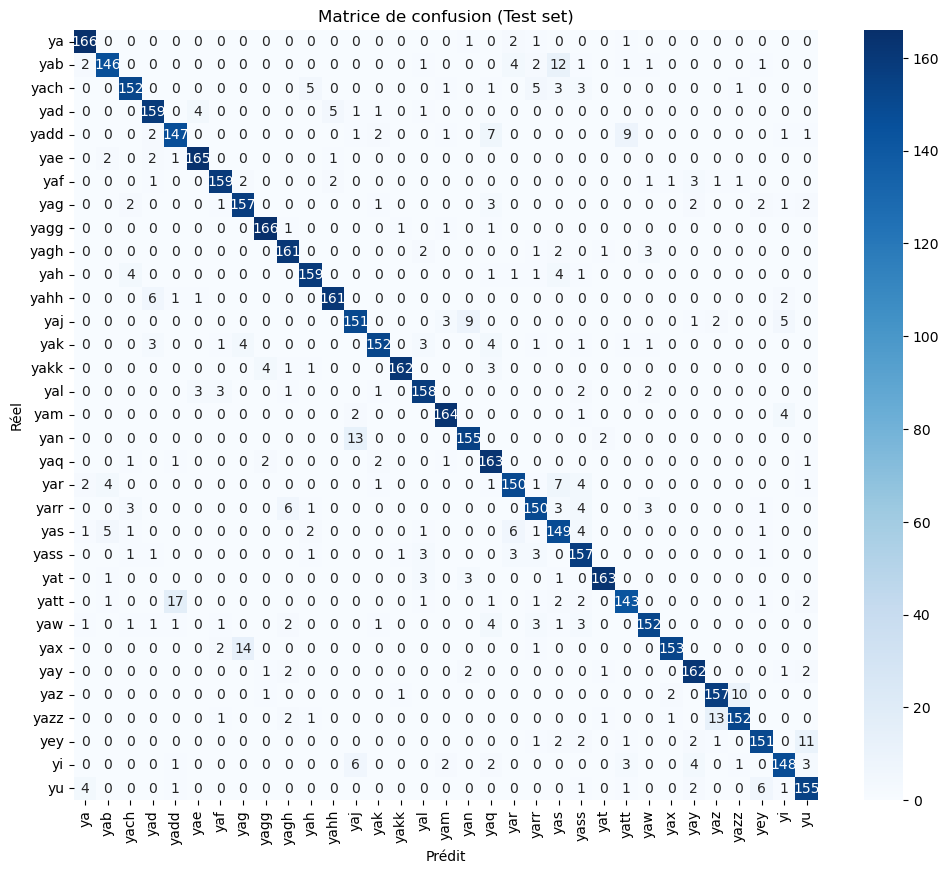

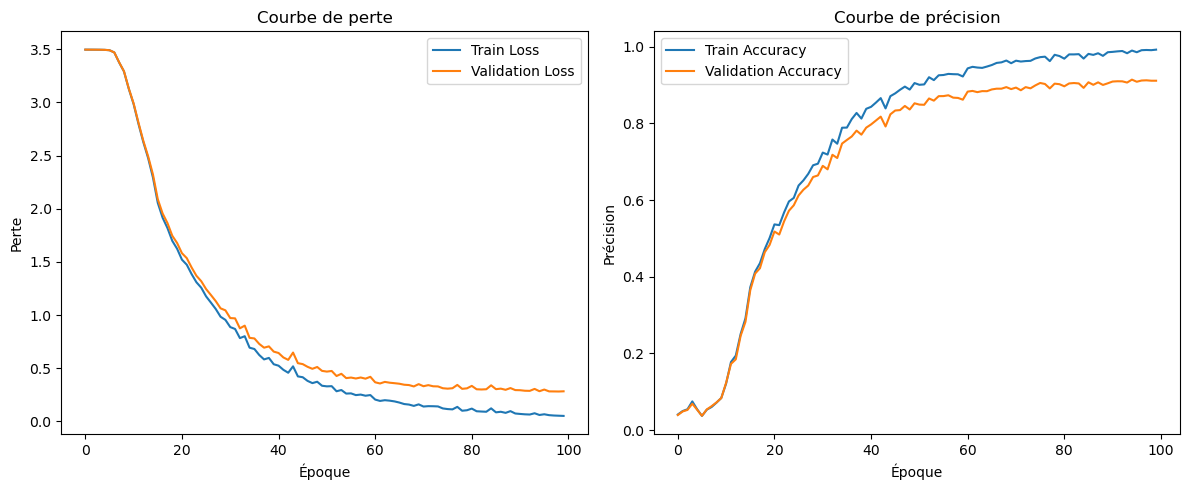

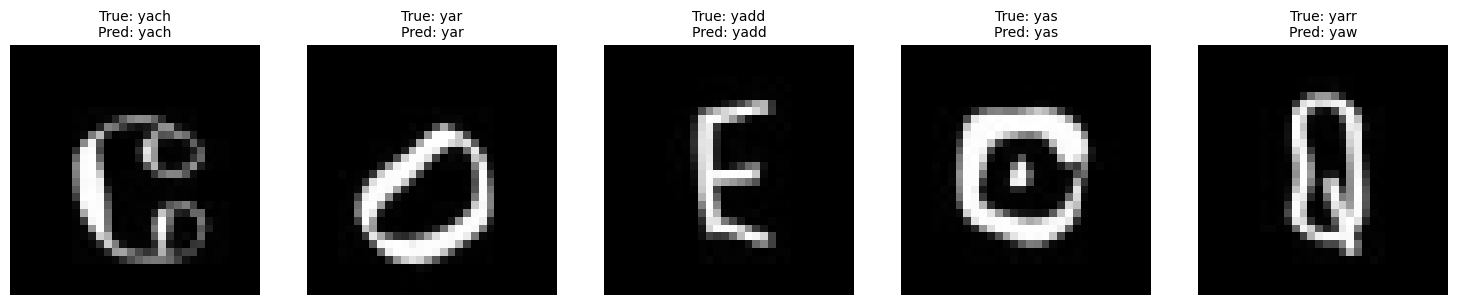

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Fonctions d'activation
def relu(x):
    """ReLU activation: max(0, x)"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    return (x > 0).astype(float)

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Classe MultiClassNeuralNetwork
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, lambda_reg=0.001):
        """Initialize the neural network with given layer sizes and learning rate"""
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.weights = []
        self.biases = []
        
        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def forward(self, X):
        """Forward propagation"""
        self.activations = [X]
        self.z_values = []
        
        # Propagation through hidden layers
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            a = relu(z)
            self.activations.append(a)
        
        # Output layer
        z_output = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z_output)
        output = softmax(z_output)
        self.activations.append(output)
        
        return output
    
    def compute_loss(self, y_true, y_pred):
        """Categorical Cross-Entropy Loss with L2 regularization"""
        # Clip pour éviter log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        m = y_true.shape[0]
        
        # Cross-entropy loss
        cross_entropy = -np.sum(y_true * np.log(y_pred)) / m
        
        # L2 Regularization
        l2_penalty = 0
        for w in self.weights:
            l2_penalty += np.sum(np.square(w))
        l2_penalty = (self.lambda_reg / (2 * m)) * l2_penalty
        
        return cross_entropy + l2_penalty
    
    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy: proportion of correct predictions"""
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)
    
    def backward(self, X, y_true, y_pred):
        """Backpropagation with L2 regularization"""
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        
        # Gradient for output layer
        dZ = y_pred - y_true
        
        # Output layer gradients
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m + (self.lambda_reg / m) * self.weights[-1]
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        
        # Backpropagate through hidden layers
        for l in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[l+1].T
            dZ = dA * relu_derivative(self.z_values[l])
            
            self.d_weights[l] = (self.activations[l].T @ dZ) / m + (self.lambda_reg / m) * self.weights[l]
            self.d_biases[l] = np.sum(dZ, axis=0, keepdims=True) / m
    
    def update_parameters(self):
        """Update parameters using SGD"""
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the neural network using mini-batch SGD"""
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(X_train.shape[0])
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            epoch_loss = 0
            for i in range(0, X_train.shape[0], batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                batch_loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss
                
                # Backward pass
                self.backward(X_batch, y_batch, y_pred)
                self.update_parameters()
            
            # Average epoch loss
            epoch_loss /= (X_train.shape[0] // batch_size)
            
            # Training metrics
            train_pred = self.forward(X_train)
            train_loss = self.compute_loss(y_train, train_pred)
            train_accuracy = self.compute_accuracy(y_train, train_pred)
            
            # Validation metrics
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)
            
            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            # Log progress
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        return train_losses, val_losses, train_accuracies, val_accuracies
    
    def predict(self, X):
        """Predict class labels"""
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)

# --- Chargement et prétraitement des données RGB ---
base_dir = 'C:/Users/hp/Desktop/BBB'  # Répertoire de base
data_dir = os.path.join(base_dir, 'tifinagh-images')  # Dossier des images
csv_path = os.path.join(base_dir, 'amhcd-data-64', 'labels-map.csv')  # Chemin du CSV

# Charger les étiquettes
if os.path.exists(csv_path):
    labels_df = pd.read_csv(csv_path)
    # Vérification des colonnes
    if 'label' not in labels_df.columns and len(labels_df.columns) >= 2:
        labels_df = labels_df.rename(columns={
            labels_df.columns[0]: 'image_path',
            labels_df.columns[1]: 'label'
        })
else:
    print("Building labels from directory structure...")
    image_paths = []
    labels = []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(label_path, img_name)
                    image_paths.append(img_path)
                    labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Encoder les étiquettes
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

# Fonction pour charger et prétraiter une image RGB
def load_and_preprocess_rgb_image(image_path, target_size=(32, 32)):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Charger l'image en couleur (RGB)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to read image: {image_path}")
    
    # Conversion BGR vers RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Redimensionnement et normalisation
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    
    return img.flatten()

# Charger toutes les images RGB
X = []
valid_indices = []
for i, path in enumerate(labels_df['image_path']):
    try:
        full_path = path if os.path.isabs(path) else os.path.join(data_dir, path)
        img_data = load_and_preprocess_rgb_image(full_path)
        X.append(img_data)
        valid_indices.append(i)
    except Exception as e:
        print(f"Skipping invalid image {path}: {str(e)}")

X = np.array(X)
y = labels_df.iloc[valid_indices]['label_encoded'].values

# Diviser les données
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Encodage one-hot
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))

# --- Création et entraînement du modèle ---
# Taille d'entrée: 32x32 pixels x 3 canaux = 3072
layer_sizes = [X_train.shape[1], 128, 64, num_classes]
nn = MultiClassNeuralNetwork(layer_sizes, learning_rate=0.01, lambda_reg=0.001)

print("Début de l'entraînement...")
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train_one_hot, 
    X_val, y_val_one_hot,
    epochs=100,
    batch_size=32
)

# --- Évaluation finale ---
y_pred = nn.predict(X_test)
print("\nRapport de classification (Test set):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion (Test set)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.savefig('confusion_matrix_rgb.png', dpi=300)
plt.show()

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.savefig('loss_accuracy_plot_rgb.png')
plt.show()

# Visualisation de quelques prédictions
def display_predictions(X, y_true, y_pred, label_encoder, num_samples=5):
    indices = np.random.choice(len(X), num_samples)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        img = X[idx].reshape(32, 32, 3)
        plt.imshow(img)
        true_label = label_encoder.inverse_transform([y_true[idx]])[0]
        pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('sample_predictions_rgb.png')
    plt.show()

display_predictions(X_test, y_test, y_pred, label_encoder)